# Generation of the library

## Read simulation dataset

In [1]:
import xarray as xr

info_ds = xr.open_dataset(
    "outputs/GreenSurge_Singapur_info.nc",
    decode_times=False,
)
info_ds

<xarray.Dataset> Size: 11MB
Dimensions:                            (element_computation_index: 421998,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 137,
                                        element_forcing_index: 207,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 219732)
Coordinates:
  * wind_direction_index               (wind_direction_index) int32 96B 0 ... 23
  * time_forcing_index                 (time_forcing_index) float64 32B 0.0 ....
    node_computation_longitude         (node_cumputation_index) float64 2MB ...
    node_computation_latitude          (node_cumputation_index) float64 2MB ...
    triangle_nodes                     (triangle_forcing_nodes) int32 12B ...
  * node_forcing_index                 (node_forcing_index) int32 548B 0 ... 136
  * element_forcing_index              (element_forcing_index) int32 828B 0 ....
  * node_cumputation_index             (node_cumputation_index) int32 879kB 0...
  * element_computation_index          (element_computation_index) int32 2MB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int32 5MB ...
    node_forcing_longitude             (node_forcing_index) float64 1kB ...
    node_forcing_latitude              (node_forcing_index) float64 1kB ...
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int32 2kB ...
    wind_directions                    (wind_direction_index) int32 96B ...
    total_elements                     int32 4B ...
    ...                                 ...
    wind_speed                         int32 4B ...
    location_name                      object 8B ...
    eddy_viscosity                     int32 4B ...
    chezy_coefficient                  int32 4B ...
    reference_date                     object 8B ...
    forcing_time_step                  int32 4B ...
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-06-20 11:52:44
    institution:  GeoOcean
    model:        GreenSurge

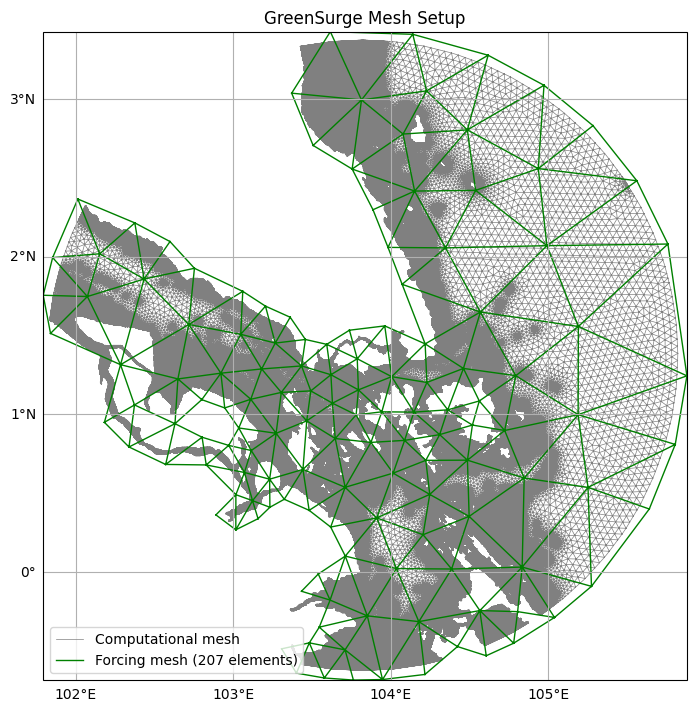

In [ ]:
from bluemath_tk.additive.greensurge import plot_greensurge_setup

fig, ax = plot_greensurge_setup(info_ds=info_ds, figsize=(7, 7))

## Wrapper input data

In [ ]:
from datetime import datetime, timedelta

import numpy as np

# Wind drag coefficients and thresholds
wind_equilibrium_code = 2
drag_coefficients = [0.00063, 0.00723, 0.00723]
velocity_thresholds = [0, 100, 100]

wind_direction_indices = info_ds.wind_direction_index.values
element_indices = info_ds.element_forcing_index.values
num_directions = len(wind_direction_indices)
num_elements = len(element_indices)

direction_grid, element_grid = np.meshgrid(wind_direction_indices, element_indices)
flattened_directions = direction_grid.flatten()
flattened_elements = element_grid.flatten()

reference_datetime = datetime.strptime(
    str(info_ds.reference_date.values), "%Y-%m-%d %H:%M:%S"
)
simulation_end_datetime = reference_datetime + timedelta(
    hours=int(info_ds.simulation_duration_hours.values)
)

# Parameters for the metamodel (per element and direction)
metamodel_parameters = {
    "direction": flattened_directions,
    "tesela": flattened_elements,
}

# Fixed simulation parameters
fixed_parameters = {
    "MapInterval": 3600 * info_ds.time_step_hours.values,
    "RefDate": reference_datetime.strftime("%Y%m%d"),
    "StartDateTime": reference_datetime.strftime("%Y%m%d%H%M%S"),
    "StopDateTime": simulation_end_datetime.strftime("%Y%m%d%H%M%S"),
    "CDa": drag_coefficients[0],
    "CDb": drag_coefficients[1],
    "CDc": drag_coefficients[2],
    "VCDa": velocity_thresholds[0],
    "VCDb": velocity_thresholds[1],
    "VCDc": velocity_thresholds[2],
    "Wind_eq": wind_equilibrium_code,
    "eddy": info_ds.eddy_viscosity.values,
    "chezy": info_ds.chezy_coefficient.values,
    "NetFile": f"mesh_{info_ds.location_name.values}_net.nc",
    "W2Map": 1,
    "dt_forz": info_ds.forcing_time_step.values,
    "ds_GFD_info": info_ds,
    "wind_magnitude": info_ds.wind_speed.values,
    "simul_time": info_ds.simulation_duration_hours.values,
    "dir_steps": num_directions,
    "forcing_ds": ["forcing.nc"],
}


## Wraper construction

In [ ]:
from bluemath_tk.wrappers.delft3d.delft3d_wrapper import GreenSurgeModelWrapper

delft3d_wrapper = GreenSurgeModelWrapper(
    templates_dir="templates",
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir="outputs/GreenSurge_Singapur",
)

2025-06-20 10:25:28,526 - GreenSurgeModelWrapper - WARNING - Parameter direction is not in the default_parameters
2025-06-20 10:25:28,526 - GreenSurgeModelWrapper - WARNING - Parameter tesela is not in the default_parameters


## Case generation

In [ ]:
delft3d_wrapper.build_cases(
    cases_name_format=lambda ctx: f"GF_T_{ctx.get('tesela')}_D_{ctx.get('direction')}",
)

## Run cases

In [ ]:
delft3d_wrapper.run_cases(launcher="docker_serial", num_workers=10)

## Case monitorisation

In [11]:
delft3d_wrapper.monitor_cases(
    dia_file_name="dflowfmoutput/GreenSurge_GFDcase.dia",
)

,Case,Status
0,GF_T_0_D_0,FINISHED
1,GF_T_0_D_1,FINISHED
2,GF_T_0_D_2,FINISHED
3,GF_T_0_D_3,FINISHED
4,GF_T_0_D_4,FINISHED
...,...,...
4963,GF_T_206_D_19,FINISHED
4964,GF_T_206_D_20,FINISHED
4965,GF_T_206_D_21,FINISHED
4966,GF_T_206_D_22,FINISHED


## Case postprocessing

In [ ]:
delft3d_wrapper.postprocess_cases(
    ds_GFD_info=info_ds,
    parallel=False,
)